# Assignment 05

## Recommender Systems 

## CSCI E-108

### Steve Elston

## Introduction 

Recommender algorithms are widely used in commerce. Further, the basic algorithms have found applications in other areas. In this Assignment you gain some experience working with recommender data, the collaborative filtering algorithm and some versions of the nonnegative matrix factorization algorithm.           

This Assignment uses the Python [Surprise](https://surprise.readthedocs.io/en/stable/index.html) package a Scikit for recommender system experimentation. This package is in maintenance mode, but is still useful for learning recommender concepts. If you have not previously installed Surprise you will need to install it. Generally, the best way to install this older package is to run the command below from a command prompt on your system. If you have difficulty, you can refer to [this Stackoverflow thread](https://stackoverflow.com/questions/62042317/cannot-install-scikit-surprise-on-my-jupyter-notebook).      

> **Computational note:** The Surprise package was never intended as a production recommender system. If you want to explore options for production scalable recommender systems some options include:   
> 1. The Neo4J graph database contains extensive support for enterprise recommendation systems. You can see a tutorial introduction [here](https://neo4j.com/developer/cypher/guide-build-a-recommendation-engine/).   
> 2. The major cloud machine learning platforms, such as Keras and PyTorch, have increasing massive scale support for recommendation algorithms. You can find some getting started information for both [Kera](https://keras.io/examples/structured_data/collaborative_filtering_movielens/) and [PyTorch](https://pytorch.org/blog/introducing-torchrec/).

Execute the code in the cell below to import the packages you will need for this assignment. 

In [1]:
from surprise.prediction_algorithms.matrix_factorization import SVD, NMF
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.knns import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Load and Explore the Dataset   

In this Assignment you will work with the MovieLens 100k dataset. This dataset includes a total of 100,000 movie ratings from IMDB. 

Before working with recommender algorithms, you will explore these data. Exploration of data is an essential step in any data mining process.     

The code in the cell below loads the dataset and splits it into training and testing datasets. Execute this code. If you are asked if you want to download the data you must answer y. 

In [2]:
## Load the movielens-100k dataset 
## Answer y if you are asked to download the dataset
movie_lense_data = Dataset.load_builtin('ml-100k')

## Split the dataset into training and test subsets.
np.random.seed(4517)
ml_trainset, ml_testset = train_test_split(movie_lense_data, test_size=0.20)

Before experimenting with the recommender algorithms we will explore the data. As a first step of the execute the code in the cell below to print some characteristics of the training dataset.  

In [3]:
print('For training dataset:')
print("Number of users = {}".format(ml_trainset.n_users))
print("Number of items = {}".format(ml_trainset.n_items))
print("Number of ratings = {}".format(ml_trainset.n_ratings))

For training dataset:
Number of users = 943
Number of items = 1654
Number of ratings = 80000


You can see some basic characteristics of the training dataset. If these data were represented as a rectangular table or matrix they would require, over 1.5 million, and at least that many bytes. In practice, a more efficient representation is used. 

The Surprise package, like all real-world recommender software, uses a space efficient representation. The `ur` attribute of the Surprise data object contains a dictionary with the recommender data. The keys of the dictionary are numeric identifiers of the users. The values of this key-value pairs are a list of tuples. The tuples are key-value pairs, with the key being the item identifier and the rating. In summary, there is a hashed user key to item key-value pairs. This nesting of key-value pairs is necessary since Python dictionaries only support a single hashed key per value.        

The code in the cell below prints the list of key-value pairs for a single user key. There are multiple item identifier, rating, tupples for user 5. Execute this code and examine the results.   

In [4]:
## Print the product-rating tupples in the 'ur' attribute of the data object from user 6
print(f"The number of recommendations = {len(ml_trainset.ur[5])}")p
ml_trainset.ur[5]

The number of recommendations = 32


[(5, 4.0),
 (339, 4.0),
 (919, 5.0),
 (169, 4.0),
 (574, 2.0),
 (49, 2.0),
 (563, 2.0),
 (144, 5.0),
 (859, 3.0),
 (650, 1.0),
 (4, 4.0),
 (507, 3.0),
 (75, 2.0),
 (289, 2.0),
 (593, 4.0),
 (348, 2.0),
 (160, 4.0),
 (47, 5.0),
 (34, 3.0),
 (904, 2.0),
 (216, 3.0),
 (407, 3.0),
 (322, 2.0),
 (477, 1.0),
 (349, 3.0),
 (557, 4.0),
 (321, 3.0),
 (372, 3.0),
 (955, 2.0),
 (276, 5.0),
 (1069, 4.0),
 (616, 4.0)]

User 5 has only rated 32 items of 1647 total items.     

> **Exercise 05-1:** To gain some understanding of the nature of the ratings, in the cell below create and execute code to compute and print two summary statistics in decimal fraction format. Use the attributes of the training dataset to extract the required parameters. See the foregoing example for an example of accessing the attributes of the data object.        
> 1. Fraction of all items rated by user 5. 
> 2. The fraction of possible item-user pairs in the utility matrix that have non-null values.    

In [5]:
## Put your code here
fration_user_item = ml_trainset.n_ratings/(ml_trainset.n_items * ml_trainset.n_users)
print('Fraction of items rated by user 5 = {}'.format(len(ml_trainset.ur[5])/ml_trainset.n_items))
print("Fraction of user-item pairs rated = {}".format(fration_user_item))

Fraction of items rated by user 5 = 0.019347037484885126
Fraction of user-item pairs rated = 0.05129119163543247


> Q1. Given that real-world online catalog (products, videos, music, etc.) can contain millions of items, do you think these fractions for an individual user and the average user are realistic or too high? 

> **Answer:**  These fractions are far to high for a situation where the catalog contains millions of items. Given these ratio users would have rated 50,000 items on average for a million item catalog.  

> 3. Create two lists with the following values, a) list named `mean_ratings` containing the mean rating of each user, and b) a list named `number_ratings` that contains the count of ratings for each user. The user ratings are represented with a Python dictionary, with the user identifier as key, in the `ur` attribute of the training dataset. You can extract the keys (user identifiers) with the `keys` method.  
> 4. Once you have completed your code, execute the code in the cell below to display the histograms.  

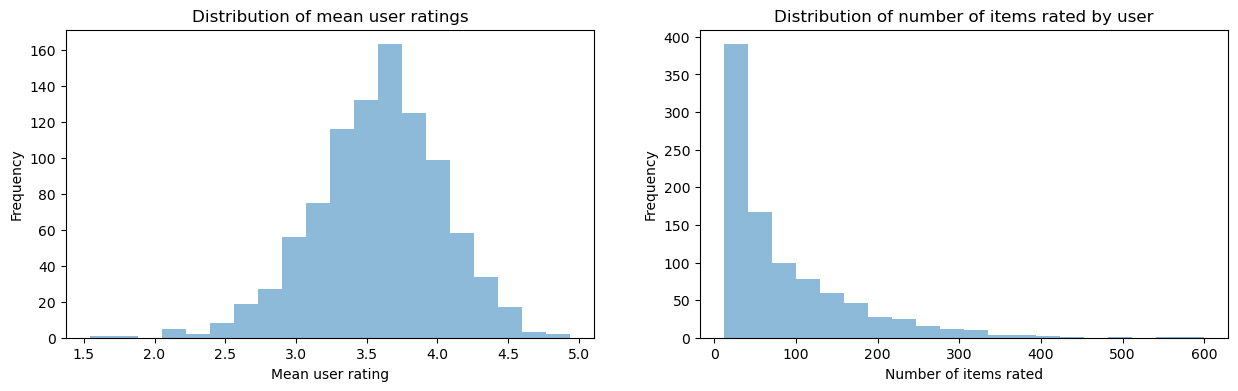

In [6]:
## Compute the mean rating for each of the users in the training dataset
## Put your code here
mean_ratings = []
number_ratings = []
for key in ml_trainset.ur.keys(): 
    number_ratings.append(len(ml_trainset.ur[key]))
    mean_ratings.append(np.mean(np.array(ml_trainset.ur[key], dtype=float)[:,1]))

    
## Create a histograms of the results
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(mean_ratings, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Mean user rating')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of mean user ratings')
_=ax[1].hist(number_ratings, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('Number of items rated')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of number of items rated by user')

> Provide short answers to the following questions:   
> Q2. Is the distribution of the mean user ratings a bit skewed? What does this skew tell us?   
> Q3. Notice the rapid decay in the frequency of items rated by users. What does this long tail tell you about user behavior?  
> **End of exercise.**

> **Answers:**   
> Q2. Yes, the distribution is skewed toward higher ratings. This skew is reasonable since users tend to bias ratings upward.          
> Q3. THe long tail of number of ratings arises since most users only rate a few items, whereas a few users will rate many items.       

## Baseline Only Model

One possible answer to the cold start problem is to use a **baseline only** model. In this model we just use the average or baseline values for users or items to predict ratings. This same approach can be applied to users who consume an item, but provide no rating.

> **Exercise 05-2:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.baseline_only.BaselineOnly](https://surprise.readthedocs.io/en/stable/basic_algorithms.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `baseline_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using [surprise.accuracy.rmse](https://surprise.readthedocs.io/en/stable/accuracy.html) and MAE using [surprise.accuracy.mae](https://surprise.readthedocs.io/en/stable/accuracy.html) with the predictions as the argument in both cases.  

In [7]:
## Instantiate the model object and fit to the training data  
# Put your code below
baseline_model = BaselineOnly()
baseline_model.fit(ml_trainset)

## Compute the predicitons from the model 
# Put your code below
predictions = baseline_model.test(ml_testset)

# Compute some model performance statistics
# Put your code below
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

Estimating biases using als...
RMSE: 0.9371
0.9370602932201032
MAE:  0.7421
0.742095152987082


> Q1. Does the accuracy performance of this model seem good given its simplicity?   

> **Answer:** The performance of predicting the ratings is relatively good given the simplicity of the model.

> 4. Execute the code in the cell below to display histograms of the item and user biases. 

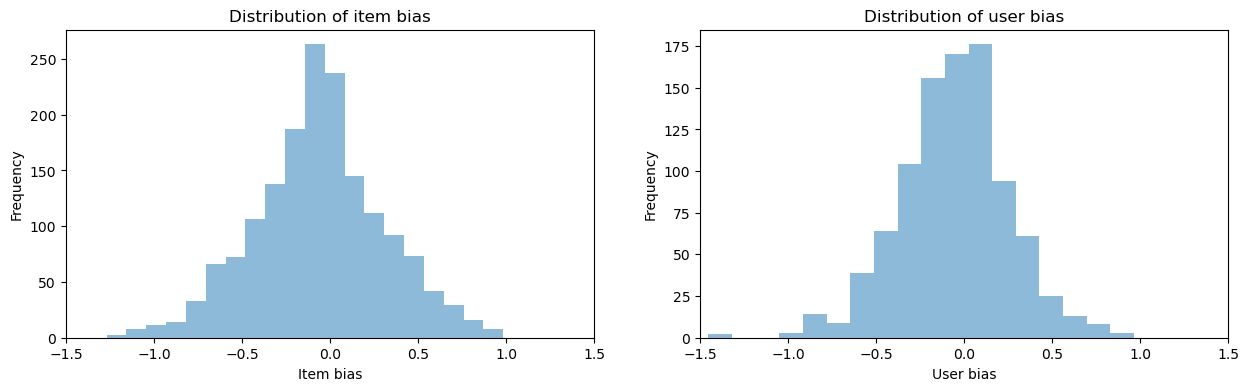

In [8]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(baseline_model.bi, bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item bias')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item bias')
_=ax[0].set_xlim(-1.5,1.5)
_=ax[1].hist(baseline_model.bu, bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User bias')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user bias')
_=ax[1].set_xlim(-1.5,1.5)

> Q2. These bias values are approximately Normally distributed, but with somewhat heavy tails. Examine the range of these biases. What does the fact that these ranges are small compared to the range of ratings tell you about the magnitude of the bias adjustments?      

> **Answer:** The biases have a small range compared the range of the rating values     

> 5. Ideally, the biases should be uniformly distributed with identifier. In other words, statistically independent of the identifiers. Execute the code to display the relationship. 

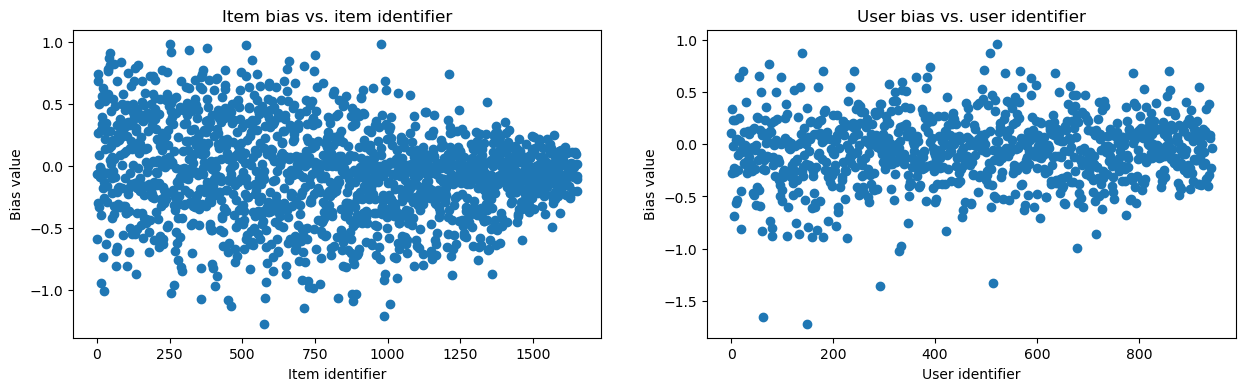

In [9]:
## plot the biases
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].scatter(range(len(baseline_model.bi)), baseline_model.bi) 
_=ax[0].set_xlabel('Item identifier')
_=ax[0].set_ylabel('Bias value')
_=ax[0].set_title('Item bias vs. item identifier')
_=ax[1].scatter(range(len(baseline_model.bu)), baseline_model.bu) 
_=ax[1].set_xlabel('User identifier')
_=ax[1].set_ylabel('Bias value')
_=ax[1].set_title('User bias vs. user identifier')

> Q3. Does the distribution of the biases look largely uniform with item identifier or not?    
> Q4. Does the distribution of the biases look largely uniform with user identifier or not?   

> **Answers:**   
> Q3. The distribution of the biases is mostly uniform with item identifier, but the range of biases becomes smaller at high identifier numbers for some reason.          
> Q4. The distribution of the biases is mostly uniform with user identifier.       

## Collaborative Filtering Model  

The collaborative filtering model is an unsupervised learning model using similarity item-item or user-user similarity measures. Items with the highest similarity measures are recommended.  

> **Exercise 05-3:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.knns.KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `collaborative_filter_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [10]:
## Instantiate the model object and fit to the training data  
## Put your code here
collaborative_filter_model = KNNBasic()
collaborative_filter_model.fit(ml_trainset)

## Compute the predicitons from the model 
## Put your code here
predictions = collaborative_filter_model.test(ml_testset)

# Compute some model performance statistics
## Put your code here
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9676
0.9676139209075455
MAE:  0.7636
0.7636210441523836


> Provide short answers to the following questions:     
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on similarity.    
  

> **Answers:**       
> Q1. The accuracy of the collaborative filtering model is a bit worse than the baseline model. This indicates that the biases in these data are quite significant and predictive.       
> Q2. For a less dense utility matrix the accuracy of the collaborative filtering algorithm is likely to be better since the baseline model only uses averages or biases, whereas collaborative filtering uses similarity between (possibly sparse) rating values. In other words, one expects the variance of the baseline estimates to become worse as the utility matrix becomes more sparse faster than for a similarity measure used for collaborative filtering.       

> 4. The distribution of the similarities gives insight into the behavior of the model. Execute the code in the to display the histogram of the user-user similarity measures.   

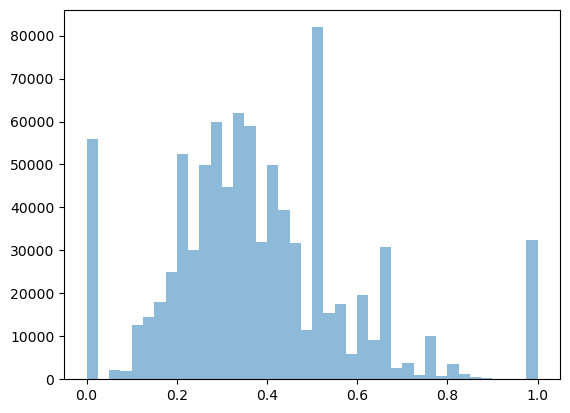

In [11]:
_=plt.hist(collaborative_filter_model.sim.flatten(), bins=40, alpha=0.5)

> Q3. Examine the plot. Notice there are a number of similarities which are or are close to 0 or 1, and another spike around 0.5. Is the distribution of these similarities skewed? If so, what does this skew tell you about how strong a predictor similarity can be in this case.    
> **End of exercise.**

> **Answer:** The similarities are are generally low, with the bulk of the distribution less than 0.5. It is likely that similarity is a weak predictor.          

In [12]:

for i in range(len(baseline_model.bu)):
    user_bias = baseline_model.bu[i]
    

In [13]:
baseline_model.bi

array([-0.58509559, -0.06843149,  0.73803638, ...,  0.01910416,
       -0.20486414, -0.07925491])

In [14]:
ml_trainset.ur[20][0][1]

1.0

In [15]:
ml_trainset

## Instantiate the model object and fit to the training data  
## Put your code here
collaborative_filter_model = KNNBasic()
collaborative_filter_model.fit(ml_trainset)

## Compute the predicitons from the model 
## Put your code here
predictions = collaborative_filter_model.test(ml_testset)

# Compute some model performance statistics
## Put your code here
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9676
0.9676139209075455
MAE:  0.7636
0.7636210441523836


## Matrix Factorization Methods   

Matrix factorization algorithms are generally considered to be the state of the art for recommenders. The matrix factorization methods find a set of latent (non-observable) factor variable values, which are used to compute rating estimates. Additionally, user and item rating bias adjustments are applied.    

> **Exercise 05-4:** You will now create and evaluate a baseline recommender model. Do the following:   
> 1. Instantiate a [surprise.prediction_algorithms.matrix_factorization.SVD](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) model object and it with the `fit` method using the `ml_trainset` as the argument. Name your model object `collaborative_filter_model`.  
> 2. Compute the recommender predictions with the `test` method using the `ml_testset` as the argument.   
> 3. Compute and print the RMSE using `surprise.accuracy.rmse` and MAE using `surprise.accuracy.mae` with the predictions as the argument in both cases.  

In [16]:
## Instantiate the model object and fit to the training data  
## Put your code here
n_factors=10
svd_model = SVD(n_factors=n_factors)
svd_model.fit(ml_trainset)

## Compute the predicitons from the model 
## Put your code here
predictions = svd_model.test(ml_testset)

# Compute some model performance statistics
## Put your code here
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

RMSE: 0.9292
0.9292088042100402
MAE:  0.7326
0.7325926842851989


> Provide short answers to the following questions:   
> Q1. Compare the performance of this model to the baseline model. Is it better or worse?     
> Q2. Keeping in mind that the rating sampling is more dense that a real-world example, what does this tell you about the effectiveness of a baseline model vs. the model based on latent factors.    


> **Answers:**       
> Q1. The accuracy of the latent variable model is better than for the baseline model.      
> Q2. For a less dense utility matrix the accuracy of the latent variable algorithm is likely to be better since the baseline model only uses averages or biases, whereas, the latent variable model uses multiple factors to estimate ratings.     

> 4. The distribution of the item and factor values gives insight into the behavior of the model. Execute the code in the to display the histograms of the factors for items and users.     

Shape of item factor matrix: (1654, 10)
Shape of user factor matrix: (943, 10)


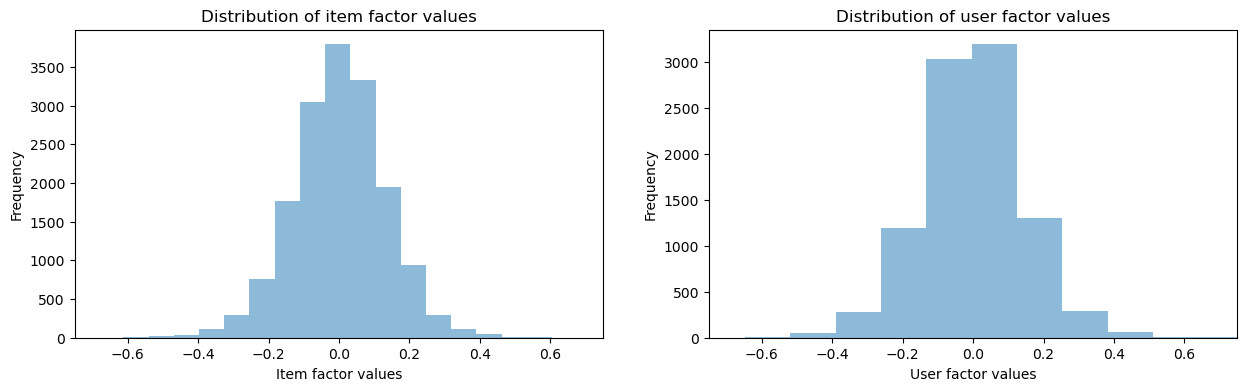

In [17]:
print('Shape of item factor matrix: {}'.format(svd_model.qi.shape))
print('Shape of user factor matrix: {}'.format(svd_model.pu.shape))

## Create a histograms of the factor values
fig,ax= plt.subplots(1,2,figsize=(15,4))
_=ax[0].hist(svd_model.qi.flatten(), bins=20, alpha=0.5) 
_=ax[0].set_xlabel('Item factor values')
_=ax[0].set_ylabel('Frequency')
_=ax[0].set_title('Distribution of item factor values')
_=ax[0].set_xlim(-.75,.75)
_=ax[1].hist(svd_model.pu.flatten(), bins=20, alpha=0.5) 
_=ax[1].set_xlabel('User factor values')
_=ax[1].set_ylabel('Frequency')
_=ax[1].set_title('Distribution of user factor values')
_=ax[1].set_xlim(-.75,.75)

In [18]:
## Optional exact calculation of compression of factor model   
n_reviews = 0
for key in ml_trainset.ur.keys(): 
    n_reviews += len(ml_trainset.ur[key])
print(f"Total number of reviews = {n_reviews}")
utility_bytes = 8*n_reviews + 4*ml_trainset.n_users
print(f"Bytes for all review tuples = {utility_bytes}")

P_size = n_factors * ml_trainset.n_users
Q_size = n_factors * ml_trainset.n_items
print(f"Values in P = {P_size}")
print(f"Values in Q = {Q_size}")
PQ_bytes = 4 * (P_size + Q_size)
print(f"Total bytes for P + Q = {PQ_bytes}")
print(f"Compression for factor model = {utility_bytes/PQ_bytes}")

Total number of reviews = 80000
Bytes for all review tuples = 643772
Values in P = 9430
Values in Q = 16540
Total bytes for P + Q = 103880
Compression for factor model = 6.197266076241817


> Provide short answers to the following questions:     
> Q3. Notice the dimensions of factor matrices computed, Q, P. Is this representation compact compared to the original data set, and why?     
> Q4. Examine the distribution of the factor values. Compare these values to the distribution of baseline or bias values for the Baseline model. What do the differences in the range of values tell you about the effect of subtracting the bias terms before computing the factor values?     
> **End of exercise.**

> **Answers:**   
> Q3. The representation of the factor matrices, Q and P, is much more compact when compared to the utility matrix. The number of columns in each factor matrix is only the number of factors, a number much smaller that either the number of users or items.           
> Q4. The range of factor variables is much smaller than range of bias values. This relationship indicates that the factor values only represent small changes from the baseline or bias values and makes the variance of the factor estimates significantly lower.       

#### Copyright 2021, 2022, 2023, Stephen F Elston. All rights reserved. 